In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("C:\\Users\\Simon\\PycharmProjects\\NeuronaleNetze\\data\\heart.csv")
#Modify categorical data
# Get one hot encoding of columns B
one_hot = pd.get_dummies(data['cp'],dtype="int")
# Drop column B as it is now encoded
data = data.drop('cp',axis = 1)
# Join the encoded df
data = data.join(one_hot)
data = data.sample(frac = 1)
data.columns = data.columns.astype(str)

y = data["output"].values
x = data.drop("output", axis=1).values

enc = StandardScaler()
x = enc.fit_transform(x)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

from torch.utils.data import Dataset,DataLoader
class HeartData(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.Y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
    def __getitem__(self, item):
        return self.X[item],self.Y[item]
    def __len__(self):
        return self.len

batchsize= 32
train_data = HeartData(xtrain,ytrain)
test_data = HeartData(xtest,ytest)
train_loader = DataLoader(dataset=train_data,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=batchsize,shuffle=True)

In [3]:
class TorchNet(nn.Module):
    def __init__(self):
        super(TorchNet, self).__init__()
        self.layer1 = nn.Linear(16,12)
        self.fn1 = nn.ReLU()
        self.layer2 = nn.Linear(12,8)
        self.fn2 = nn.ReLU()
        self.layer3 = nn.Linear(8,1)
        self.fn3 = nn.Sigmoid()

    def forward(self,x):
        x = self.fn1(self.layer1(x))
        x = self.fn2(self.layer2(x))
        x = self.fn3(self.layer3(x))
        return x

In [4]:
fnn = TorchNet()
loss_fn = nn.BCELoss()
optimizer=torch.optim.SGD(fnn.parameters(),lr=0.15)

learning_rate = 0.15

loss_values = []
tmp_loss = []
accuracies = []
tmp_accuracies = []


num_epochs = 50
for epoch in range(num_epochs):
    tmp_loss = []
    tmp_accuracies = []
    for X,y in train_loader:
        optimizer.zero_grad()
        pred = fnn(X)

        loss = loss_fn(pred,y.unsqueeze(-1))
        tmp_loss.append(loss.item())

        accuracy = torch.mean(1-torch.abs(pred - y.unsqueeze(-1)))
        tmp_accuracies.append(accuracy.item())

        loss.backward()
        optimizer.step()
    loss_values.append(np.mean(tmp_loss))
    accuracies.append(np.mean(tmp_accuracies))
fnn.eval()
loss_values_test = []
accuracies_test = []
with torch.no_grad():
    for X,y in test_loader:
        pred = fnn(X)
        loss = loss_fn(pred,y.unsqueeze(-1))
        loss_values_test.append(loss.item())
        accuracy = torch.mean(1-torch.abs(pred - y.unsqueeze(-1)))
        accuracies_test.append(accuracy.item())

print(np.mean(loss_values_test))
print(np.mean(accuracies_test))

0.5902703404426575
0.7356522381305695


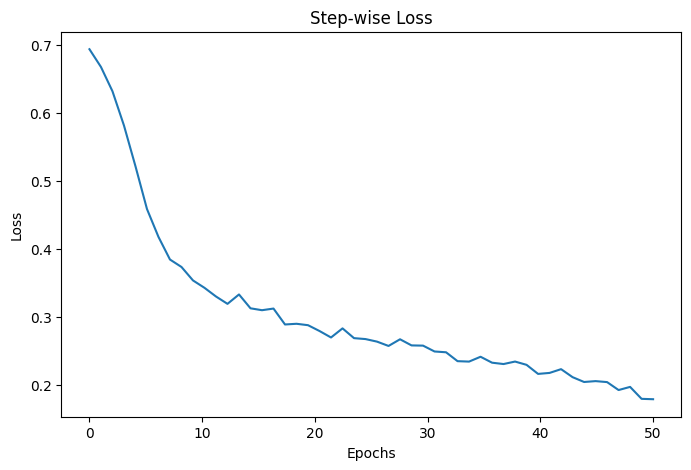

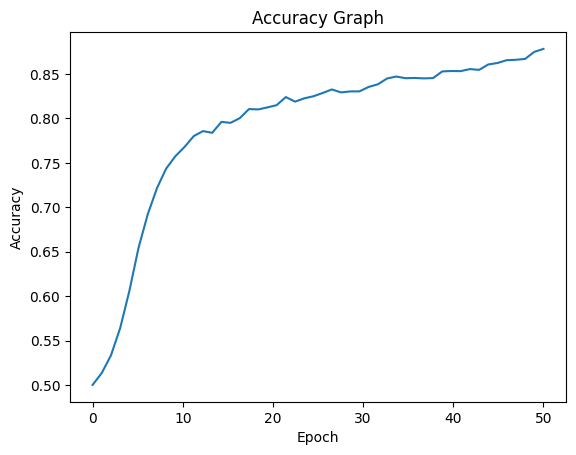

In [6]:
from matplotlib import pyplot as plt

step = np.linspace(0, 50, 50)

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(step,np.array(accuracies))
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()